## Preamble

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('/home/hosilva/tools/mplstyle/timesnromanstyle.mplstyle')

import lal, lalsimulation

from pesummary.core.plots.bounded_1d_kde import ReflectionBoundedKDE
from postprocessing_tools import read_relevant_columns, get_dimensionless_coupling_posterior, get_threshold

from __future__ import unicode_literals

In [2]:
import json

posterior_file = open('/home/hosilva/parspec/spinqnm/papers/paper_alt_theor_bounds/paper_results_paths.json')
dataloc = json.load(posterior_file)

In [13]:
from scipy.interpolate import InterpolatedUnivariateSpline as ius

### Extra utility functions

In [161]:
def joint_likelihood_and_posterior(df1, df2, pr1max, pr2max):

    import scipy.ndimage.filters as filter
    from scipy.interpolate import InterpolatedUnivariateSpline as ius
    
    def gf(P):
        return filter.gaussian_filter(P, sigma=2.0)
    
    # priors ranges
    pr1range = [0, pr1max]
    pr2range = [0, pr2max]

    Nbins = 50
    
    lbins1 = np.linspace(pr1range[0], pr1range[1], Nbins)
    lintp1 = (lbins1[:-1] + lbins1[1:])/2.

    lbins2 = np.linspace(pr2range[0], pr2range[1], Nbins)
    lintp2 = (lbins2[:-1] + lbins2[1:])/2.

    dl1 = np.mean(np.diff(lbins1))
    dl2 = np.mean(np.diff(lbins2))
    
    # prior histograms
    prl1, lbins1 = np.histogram(np.random.uniform(pr1range[0], pr1range[1], 1000000), bins=lbins1, density=True)
    prl2, lbins2 = np.histogram(np.random.uniform(pr2range[0], pr2range[1], 1000000), bins=lbins2, density=True)
    
    # posterior histograms
    Pl1, lbins1 = np.histogram(df1['alphangr'], bins=lbins1, density=True)
    Pl2, lbins2 = np.histogram(df2['alphangr'], bins=lbins2, density=True)
    
    # likelihoods
    likel1 = Pl1/prl1
    likel2 = Pl2/prl2

    likel1 /= np.sum(likel1) * dl1
    likel2 /= np.sum(likel2) * dl2
    
    # joint likelihood
    if (pr1max > pr2max) or (pr2max == pr2max):
        dl = dl1
        pr = prl1
        lintp = lintp1
        prmax = pr1max
    else:        
        dl = dl2
        pr = prl2
        lintp = lintp2
        prmax = pr2max
        
    likel = likel1*likel2
    likel /= np.sum(likel) * dl # chose dl1 because dl1=dl2

    # joint posterior
    Pl = likel * pr # chose one of the priors because they were identical
    Pl /= np.sum(Pl) * dl # chose dl1 because dl1=dl2
    
    # return lintp1, lintp2, likel, Pl

    l_vals = np.arange(0, prmax + 1)
    jlike = gf(likel)
    jpost = gf(Pl)
    
    jlike_interp = ius(lintp, jlike, k=2)
    jpost_interp = ius(lintp, jpost, k=2)
    
    # plt.plot(lintp, gf(likel))
    # plt.plot(l_vals, jlike_interp(l_vals))
    
    # print(l_vals)
    # print(l_vals.max(), jlike_interp.integral(0, 80.))
    
    # plt.plot(lintp, gf(Pl))
    # plt.plot(l_vals, jpost_interp(l_vals))    
    
    return l_vals, jlike_interp(l_vals) / jlike_interp.integral(l_vals.min(), l_vals.max()), jpost_interp(l_vals) / jpost_interp.integral(l_vals.min(), l_vals.max())

In [25]:
def find_cdf_at_threshold(m, l_tmp, pdf_tmp, lmax=60):

    from scipy.interpolate import InterpolatedUnivariateSpline as ius
    from scipy.optimize import brentq
    
    # Create an interpolating function for the posterior
    pdf_l_tmp = ius(l_tmp, pdf_tmp)
    
    # Calculate CDF at sample values of l by integrating the posterior
    l_vals = np.arange(0, lmax + 1, 1)
    cdf_tmp = [pdf_l_tmp.integral(0, lmax) for lmax in l_vals]
    cdf_l_tmp = ius(l_vals, cdf_tmp)
    
    # Find where it is 90%
    def find_x90(x): return cdf_l_tmp(x) - 0.90
    def find_x68(x): return cdf_l_tmp(x) - 0.68
    x90 = brentq(find_x90, 0, max(l_vals))
    x68 = brentq(find_x68, 0, max(l_vals))
    
    # Given the mass samples, find its median in units of km
    Msun_to_km = 1.476
    m_median = np.median(m) * Msun_to_km
    
    print(x68, x90, 0.5 * m_median)
    
    # Set a number of epsilon and calculate the thresholds values
    epsilon_vals  = np.arange(0, 1.0 + 0.01, 0.01)
    m_thresholds  = np.array([(m_median * eps) for eps in epsilon_vals]) # in km

    # Finally, calculate the cdf at the threshold values
    cdf_at_m_thresholds = np.array([cdf_l_tmp(m) for m in m_thresholds])
    
    return epsilon_vals, cdf_at_m_thresholds

In [228]:
def find_bound(l_vals, pdf_vals):

    from scipy.interpolate import InterpolatedUnivariateSpline as ius
    from scipy.optimize import brentq
        
    pdf_l = ius(l_vals, pdf_vals)

    xlimit = np.arange(0, l_vals.max() + 1, 1)
    cdf_l_list = [pdf_l.integral(0, xmax) for xmax in xlimit]

    cdf_l_combined = ius(xlimit, cdf_l_list)

    def find_x90(x): return cdf_l_combined(x) - 0.90
    def find_x68(x): return cdf_l_combined(x) - 0.68

    result_90 = brentq(find_x90, l_vals.min(), l_vals.max())
    result_68 = brentq(find_x68, l_vals.min(), l_vals.max())
    
    print(result_68, result_90)
    
    return result_68, result_90

## 1. Posterior plots

### 1.a. dynamical Chern-Simons gravity

In [5]:
data_GW200129_dcs_j0 = np.genfromtxt(dataloc['dCS']['spin0']['GW200129'], names=True, dtype=None)
data_GW200129_dcs_j1 = np.genfromtxt(dataloc['dCS']['spin1']['GW200129'], names=True, dtype=None)
data_GW150914_dcs_j0 = np.genfromtxt(dataloc['dCS']['spin0']['GW150914'], names=True, dtype=None)
data_GW150914_dcs_j1 = np.genfromtxt(dataloc['dCS']['spin1']['GW150914'], names=True, dtype=None)

In [215]:
GW200129_dcs_smp_l_j0, GW200129_dcs_smp_m1s_j0, GW200129_dcs_smp_m2s_j0, GW200129_dcs_smp_mfs_j0, GW200129_dcs_smp_z_j0 = read_relevant_columns(data_GW200129_dcs_j0)
GW200129_dcs_smp_l_j1, GW200129_dcs_smp_m1s_j1, GW200129_dcs_smp_m2s_j1, GW200129_dcs_smp_mfs_j1, GW200129_dcs_smp_z_j1 = read_relevant_columns(data_GW200129_dcs_j1)

GW150914_dcs_smp_l_j0, GW150914_dcs_smp_m1s_j0, GW150914_dcs_smp_m2s_j0, GW150914_dcs_smp_mfs_j0, GW150914_dcs_smp_z_j0 = read_relevant_columns(data_GW150914_dcs_j0)
GW150914_dcs_smp_l_j1, GW150914_dcs_smp_m1s_j1, GW150914_dcs_smp_m2s_j1, GW150914_dcs_smp_mfs_j1, GW150914_dcs_smp_z_j1 = read_relevant_columns(data_GW150914_dcs_j1)

In [225]:
dcs_prior_j0, dcs_jlike_j0, dcs_jpost_j0 = joint_likelihood_and_posterior(data_GW150914_dcs_j0, data_GW200129_dcs_j0, 60., 60.)
dcs_prior_j1, dcs_jlike_j1, dcs_jpost_j1 = joint_likelihood_and_posterior(data_GW150914_dcs_j1, data_GW200129_dcs_j1, 60., 60.)

/local/tmp/hosilva/ipykernel_1632243/1394862408.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


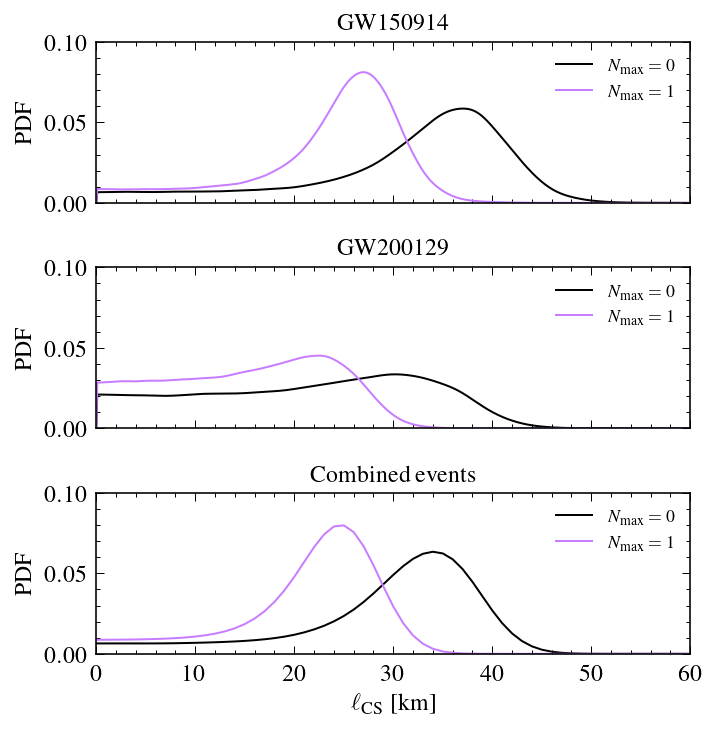

In [226]:
l_bins=np.arange(0, 60 + 1/10., 1/10.)

x = [['A', 'A', 'A'],
     ['B', 'B', 'B'],
     ['C', 'C', 'C']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.6, 'bottom':0.1})
plt.tight_layout()

clist = ["k", "#c77dff"]

for k in ('A', 'B', 'C'):
    axes[k].set_xlim(0, 60)
    axes[k].xaxis.set_ticks(np.arange(0, 60+10, 10))
    
for k in ('A', 'B'):
    axes[k].set_xticklabels([]);
    
axes['C'].set_xlabel(r'$\ell_{\rm CS}$ [km]');

#axes['A'].hist(GW150914_dcs_l,      density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
#axes['A'].hist(GW150914_spin_dcs_l, density=True, histtype='step', bins=25, ls='--', label=r"$j=0,1$");

GW150914_kde_j0 = ReflectionBoundedKDE(GW150914_dcs_smp_l_j0, xlow=min(GW150914_dcs_smp_l_j0))
axes['A'].plot(l_bins, GW150914_kde_j0(l_bins), color=clist[0], label=r"$N_{\rm max}=0$")

GW150914_kde_j1 = ReflectionBoundedKDE(GW150914_dcs_smp_l_j1, xlow=min(GW150914_dcs_smp_l_j1))
axes['A'].plot(l_bins, GW150914_kde_j1(l_bins), color=clist[1], label=r"$N_{\rm max}=1$")

axes['A'].set_ylim(0, 0.10);
axes['A'].yaxis.set_ticks([0, 0.05, 0.10]);
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper right', fontsize=9);
axes['A'].set_ylabel("PDF");

GW200129_kde_j0 = ReflectionBoundedKDE(GW200129_dcs_smp_l_j0, xlow=min(GW200129_dcs_smp_l_j0))
axes['B'].plot(l_bins, GW200129_kde_j0(l_bins), color=clist[0], label=r"$N_{\rm max}=0$")

GW200129_kde_j1 = ReflectionBoundedKDE(GW200129_dcs_smp_l_j1, xlow=min(GW200129_dcs_smp_l_j1))
axes['B'].plot(l_bins, GW200129_kde_j1(l_bins), color=clist[1], label=r"$N_{\rm max}=1$")

axes['B'].set_ylim(0, 0.10);
axes['B'].yaxis.set_ticks([0, 0.05, 0.10]);
axes['B'].set_title("GW200129");
axes['B'].legend(loc='upper right', fontsize=9);
axes['B'].set_ylabel("PDF");

axes['C'].set_title("Combined events");
axes['C'].xaxis.set_ticks(np.arange(0, 60+10, 10))
axes['C'].set_ylabel("PDF");
axes['C'].plot(dcs_prior_j0, dcs_jpost_j0, '-',  color=clist[0], label=r"$N_{\rm max}=0$")
axes['C'].plot(dcs_prior_j1, dcs_jpost_j1, '-',  color=clist[1], label=r"$N_{\rm max}=1$")
axes['C'].legend(loc='upper right', fontsize=9);
axes['C'].set_ylim(0, 0.10);
axes['C'].yaxis.set_ticks([0, 0.05, 0.10]);

# plt.savefig('fig_output/dcs_posteriors_combined.pdf')

In [37]:
eps_val, GW150914_m2_j0 = find_cdf_at_threshold(GW150914_dcs_smp_m2s_j0, l_bins, GW150914_kde_j0(l_bins), lmax=60)
_,       GW150914_mf_j0 = find_cdf_at_threshold(GW150914_dcs_smp_mfs_j0, l_bins, GW150914_kde_j0(l_bins), lmax=60)

_,       GW150914_m2_j1 = find_cdf_at_threshold(GW150914_dcs_smp_m2s_j1, l_bins, GW150914_kde_j1(l_bins), lmax=60)
_,       GW150914_mf_j1 = find_cdf_at_threshold(GW150914_dcs_smp_mfs_j1, l_bins, GW150914_kde_j1(l_bins), lmax=60)

_,       GW200129_m2_j0 = find_cdf_at_threshold(GW200129_dcs_smp_m2s_j0, l_bins, GW200129_kde_j0(l_bins), lmax=60)
_,       GW200129_mf_j0 = find_cdf_at_threshold(GW200129_dcs_smp_mfs_j0, l_bins, GW200129_kde_j0(l_bins), lmax=60)

_,       GW200129_m2_j1 = find_cdf_at_threshold(GW200129_dcs_smp_m2s_j1, l_bins, GW200129_kde_j1(l_bins), lmax=60)
_,       GW200129_mf_j1 = find_cdf_at_threshold(GW200129_dcs_smp_mfs_j1, l_bins, GW200129_kde_j1(l_bins), lmax=60)

37.38472735255171 41.91555788073135 21.945594300746336
37.38472735255171 41.91555788073135 45.5430515643193
27.630054696327928 31.026929270068084 21.95010562860401
27.630054696327928 31.026929270068084 45.64202787595715
28.79135923463992 35.83603792853574 21.409608496239574
28.79135923463992 35.83603792853574 43.82027561278758
20.708076201262788 25.877353042006302 21.43991861409669
20.708076201262788 25.877353042006302 43.88526652377499


/local/tmp/hosilva/ipykernel_1632243/2975961906.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


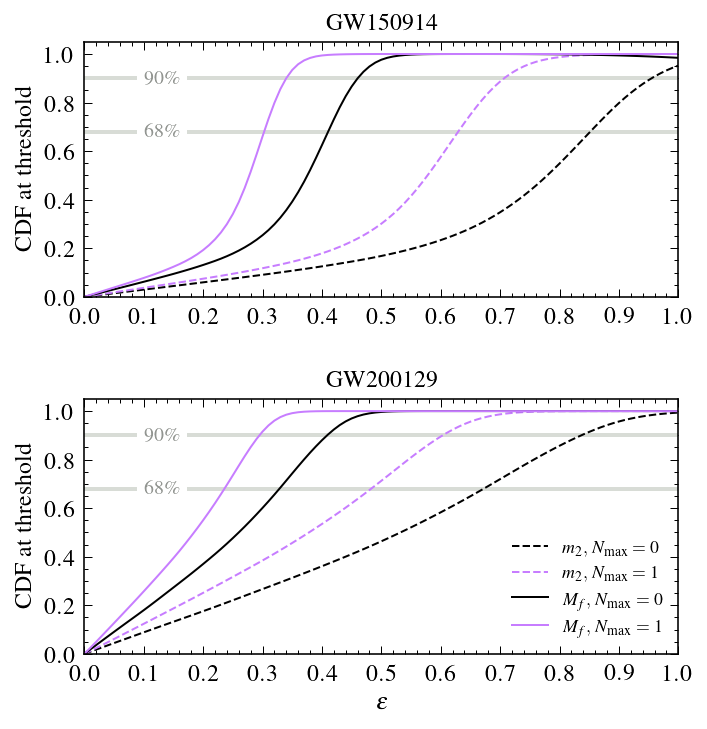

In [55]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B']]

clist = ["k", "#c77dff"]
lslist = ["dashed", "solid"]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.5, 'bottom': 0.1})
plt.tight_layout()

for k in ('A', 'B'):
    axes[k].set_xlim(0, 1)
    axes[k].set_ylim(0, 1.05)
    axes[k].xaxis.set_ticks(np.arange(0, 1 + 0.1, 0.1))
    axes[k].axhline(0.90, color='xkcd:light gray', lw=2)
    axes[k].axhline(0.68, color='xkcd:light gray', lw=2)

# -------
# Panel A
# -------
axes['A'].plot(eps_val, GW150914_m2_j0, color=clist[0], ls=lslist[0], label=r"$m_{2}, \, j=0$")
axes['A'].plot(eps_val, GW150914_m2_j1, color=clist[1], ls=lslist[0], label=r"$m_{2}, \, j=0,1$")
axes['A'].plot(eps_val, GW150914_mf_j0, color=clist[0], ls=lslist[1], label=r"$M_{f}, \, j=0$")
axes['A'].plot(eps_val, GW150914_mf_j1, color=clist[1], ls=lslist[1], label=r"$M_{f}, \, j=0,1$")
axes['A'].set_ylabel('CDF at threshold')
axes['A'].set_title("GW150914");
axes['A'].text(0.1, 0.90 - 0.03, r'$90\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
axes['A'].text(0.1, 0.68 - 0.02, r'$68\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
# axes['A'].legend(loc='lower right', frameon=False, fontsize=9, facecolor='white', edgecolor='white');
axes['A'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

# -------
# Panel B
# -------
axes['B'].plot(eps_val, GW200129_m2_j0, color=clist[0], ls=lslist[0],  label=r"$m_{2}, \, N_{\rm max}=0$")
axes['B'].plot(eps_val, GW200129_m2_j1, color=clist[1], ls=lslist[0],  label=r"$m_{2}, \, N_{\rm max}=1$")
axes['B'].plot(eps_val, GW200129_mf_j0, color=clist[0], ls=lslist[1],  label=r"$M_{f}, \, N_{\rm max}=0$")
axes['B'].plot(eps_val, GW200129_mf_j1, color=clist[1], ls=lslist[1],  label=r"$M_{f}, \, N_{\rm max}=1$")
axes['B'].set_ylabel('CDF at threshold')
axes['B'].set_xlabel(r'$\varepsilon$')
axes['B'].set_title("GW200129");
axes['B'].text(0.1, 0.90 - 0.03, r'$90\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
axes['B'].text(0.1, 0.68 - 0.02, r'$68\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
axes['B'].legend(loc='lower right', fontsize=9);
axes['B'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

plt.savefig('fig_output/dcs_cdf_varying_threshold.pdf')

In [247]:
delta_omega0 = 3.1964
delta_omega1 = 41.199
delta_tau0   = 6.3619
delta_tau1   = 794.66

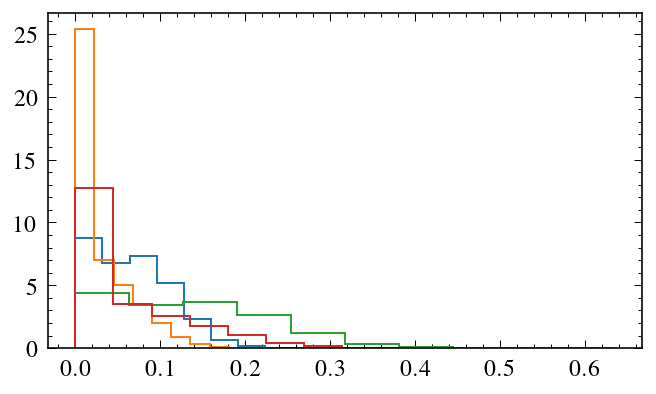

In [249]:
GW150914_gamma_j0 = get_dimensionless_coupling_posterior(GW150914_dcs_smp_l_j0, GW150914_dcs_smp_mfs_j0, p=4);
GW200129_gamma_j0 = get_dimensionless_coupling_posterior(GW200129_dcs_smp_l_j0, GW200129_dcs_smp_mfs_j0, p=4);

plt.hist(delta_omega0 * GW150914_gamma_j0, density=True, histtype='step');
plt.hist(delta_omega0 * GW200129_gamma_j0, density=True, histtype='step');

plt.hist(delta_tau0 * GW150914_gamma_j0, density=True, histtype='step');
plt.hist(delta_tau0 * GW200129_gamma_j0, density=True, histtype='step');

(0.0, 2.0)

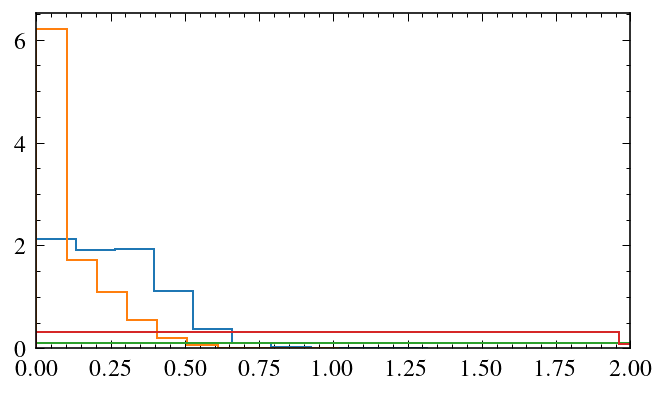

In [251]:
GW150914_gamma_j1 = get_dimensionless_coupling_posterior(GW150914_dcs_smp_l_j1, GW150914_dcs_smp_mfs_j1, p=4);
GW200129_gamma_j1 = get_dimensionless_coupling_posterior(GW200129_dcs_smp_l_j1, GW200129_dcs_smp_mfs_j1, p=4);

plt.hist(delta_omega1 * GW150914_gamma_j1, density=True, histtype='step');
plt.hist(delta_omega1 * GW200129_gamma_j1, density=True, histtype='step');

plt.hist(delta_tau1 * GW150914_gamma_j1, density=True, histtype='step');
plt.hist(delta_tau1 * GW200129_gamma_j1, density=True, histtype='step');

plt.xlim(0, 2)

In [230]:
_, _ = find_bound(l_bins, GW150914_kde_j0(l_bins))
_, _ = find_bound(l_bins, GW200129_kde_j0(l_bins))
_, _ = find_bound(dcs_prior_j0, dcs_jpost_j0)

37.38626776399458 41.91824833760002
28.800019615295582 35.8472044571403
34.60331346102213 38.71681222217232


### 1.b. Einstein-dilaton-Gauss-Bonnet

In [56]:
data_GW200129_edgb_j0 = np.genfromtxt(dataloc['EdGB']['spin0']['GW200129'], names=True, dtype=None)
data_GW200129_edgb_j1 = np.genfromtxt(dataloc['EdGB']['spin1']['GW200129'], names=True, dtype=None)
data_GW150914_edgb_j0 = np.genfromtxt(dataloc['EdGB']['spin0']['GW150914'], names=True, dtype=None)
data_GW150914_edgb_j1 = np.genfromtxt(dataloc['EdGB']['spin1']['GW150914'], names=True, dtype=None)

In [231]:
GW200129_edgb_smp_l_j0, GW200129_edgb_smp_m1s_j0, GW200129_edgb_smp_m2s_j0, GW200129_edgb_smp_mfs_j0, GW200129_edgb_smp_z_j0 = read_relevant_columns(data_GW200129_edgb_j0)
GW200129_edgb_smp_l_j1, GW200129_edgb_smp_m1s_j1, GW200129_edgb_smp_m2s_j1, GW200129_edgb_smp_mfs_j1, GW200129_edgb_smp_z_j1 = read_relevant_columns(data_GW200129_edgb_j1)

GW150914_edgb_smp_l_j0, GW150914_edgb_smp_m1s_j0, GW150914_edgb_smp_m2s_j0, GW150914_edgb_smp_mfs_j0, GW150914_edgb_smp_z_j0 = read_relevant_columns(data_GW150914_edgb_j0)
GW150914_edgb_smp_l_j1, GW150914_edgb_smp_m1s_j1, GW150914_edgb_smp_m2s_j1, GW150914_edgb_smp_mfs_j1, GW150914_edgb_smp_z_j1 = read_relevant_columns(data_GW150914_edgb_j1)

In [232]:
edgb_prior_j0, edgb_jlike_j0, edgb_jpost_j0 = joint_likelihood_and_posterior(data_GW150914_edgb_j0, data_GW200129_edgb_j0, 420., 300.)
edgb_prior_j1, edgb_jlike_j1, edgb_jpost_j1 = joint_likelihood_and_posterior(data_GW150914_edgb_j1, data_GW200129_edgb_j1, 200., 200.)

/local/tmp/hosilva/ipykernel_1632243/2524212927.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


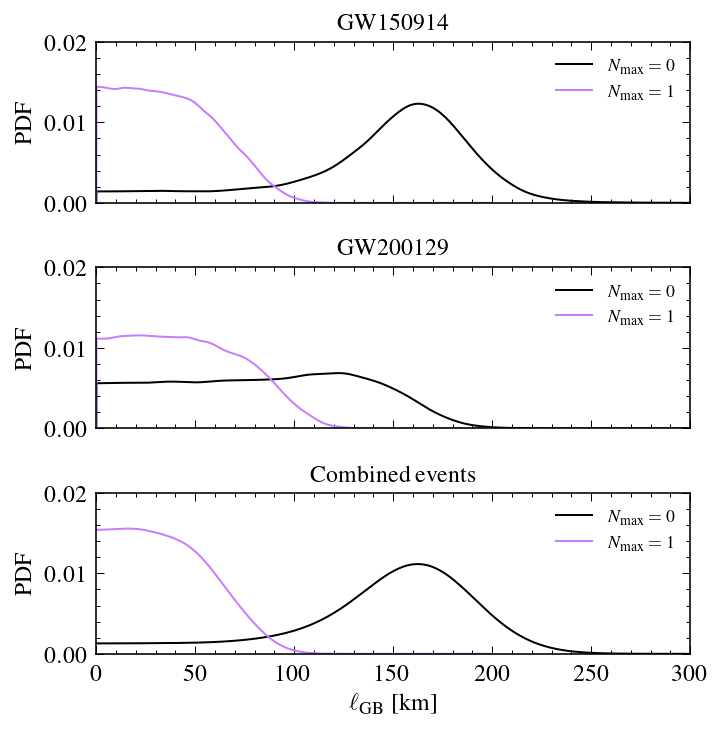

In [233]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B'],
     ['C', 'C', 'C']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.6, 'bottom':0.1})
plt.tight_layout()

clist = ["k", "#c77dff"]

for k in ('A', 'B', 'C'):
    axes[k].set_xlim(0, 300)
    axes[k].xaxis.set_ticks(np.arange(0, 300+50, 50))
    
for k in ('A', 'B'):
    axes[k].set_xticklabels([]);
    
axes['C'].set_xlabel(r'$\ell_{\rm GB}$ [km]');

#axes['A'].hist(GW150914_dcs_l,      density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
#axes['A'].hist(GW150914_spin_dcs_l, density=True, histtype='step', bins=25, ls='--', label=r"$j=0,1$");

l_bins=np.arange(0, 420 + 1/10., 1/10.)
GW150914_kde_j0 = ReflectionBoundedKDE(GW150914_edgb_smp_l_j0, xlow=min(GW150914_edgb_smp_l_j0))
axes['A'].plot(l_bins, GW150914_kde_j0(l_bins), color=clist[0], label=r"$N_{\rm max}=0$")

l_bins=np.arange(0, 200 + 1/10., 1/10.)
GW150914_kde_j1 = ReflectionBoundedKDE(GW150914_edgb_smp_l_j1, xlow=min(GW150914_edgb_smp_l_j1))
axes['A'].plot(l_bins, GW150914_kde_j1(l_bins), color=clist[1], label=r"$N_{\rm max}=1$")

axes['A'].set_ylim(0, 0.02);
axes['A'].yaxis.set_ticks([0, 0.01, 0.02]);
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper right', fontsize=9);
axes['A'].set_ylabel("PDF");

l_bins=np.arange(0, 300 + 1/10., 1/10.)
GW200129_kde_j0 = ReflectionBoundedKDE(GW200129_edgb_smp_l_j0, xlow=min(GW200129_edgb_smp_l_j0))
axes['B'].plot(l_bins, GW200129_kde_j0(l_bins), color=clist[0], label=r"$N_{\rm max}=0$")

l_bins=np.arange(0, 200 + 1/10., 1/10.)
GW200129_kde_j1 = ReflectionBoundedKDE(GW200129_edgb_smp_l_j1, xlow=min(GW200129_edgb_smp_l_j1))
axes['B'].plot(l_bins, GW200129_kde_j1(l_bins), color=clist[1], label=r"$N_{\rm max}=1$")

axes['B'].set_ylim(0, 0.02);
axes['B'].yaxis.set_ticks([0, 0.01, 0.02]);
axes['B'].set_title("GW200129");
axes['B'].legend(loc='upper right', fontsize=9);
axes['B'].set_ylabel("PDF");

axes['C'].set_title("Combined events");
axes['C'].set_ylabel("PDF");
axes['C'].plot(edgb_prior_j0, edgb_jpost_j0, '-',  color=clist[0], label=r"$N_{\rm max}=0$")
axes['C'].plot(edgb_prior_j1, edgb_jpost_j1, '-',  color=clist[1], label=r"$N_{\rm max}=1$")
axes['C'].legend(loc='upper right', fontsize=9);
axes['C'].set_ylim(0, 0.02);
axes['C'].yaxis.set_ticks([0, 0.01, 0.02]);

# plt.savefig('fig_output/edgb_posteriors_combined.pdf')

In [209]:
eps_val, GW150914_m2_j0 = find_cdf_at_threshold(GW150914_edgb_smp_m2s_j0, l_bins, GW150914_kde_j0(l_bins), lmax=420)
_,       GW150914_mf_j0 = find_cdf_at_threshold(GW150914_edgb_smp_mfs_j0, l_bins, GW150914_kde_j0(l_bins), lmax=420)

_,       GW150914_m2_j1 = find_cdf_at_threshold(GW150914_edgb_smp_m2s_j1, l_bins, GW150914_kde_j1(l_bins), lmax=200)
_,       GW150914_mf_j1 = find_cdf_at_threshold(GW150914_edgb_smp_mfs_j1, l_bins, GW150914_kde_j1(l_bins), lmax=200)

_,       GW200129_m2_j0 = find_cdf_at_threshold(GW200129_edgb_smp_m2s_j0, l_bins, GW200129_kde_j0(l_bins), lmax=300)
_,       GW200129_mf_j0 = find_cdf_at_threshold(GW200129_edgb_smp_mfs_j0, l_bins, GW200129_kde_j0(l_bins), lmax=300)

_,       GW200129_m2_j1 = find_cdf_at_threshold(GW200129_edgb_smp_m2s_j1, l_bins, GW200129_kde_j1(l_bins), lmax=200)
_,       GW200129_mf_j1 = find_cdf_at_threshold(GW200129_edgb_smp_mfs_j1, l_bins, GW200129_kde_j1(l_bins), lmax=200)

168.9489226665298 192.66926023539713 22.081519018252397
168.9489226665298 192.66926023539713 45.84189029871594
49.09706239322851 71.15875494390649 22.09852657022214
49.09706239322851 71.15875494390649 44.75211027495128
114.5068853533347 149.47531532441135 21.35905928669088
114.5068853533347 149.47531532441135 43.86453770391392
60.48352528371517 85.57264140272312 21.208473371401364
60.48352528371517 85.57264140272312 43.45535842411747


/local/tmp/hosilva/ipykernel_1632243/2840978895.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


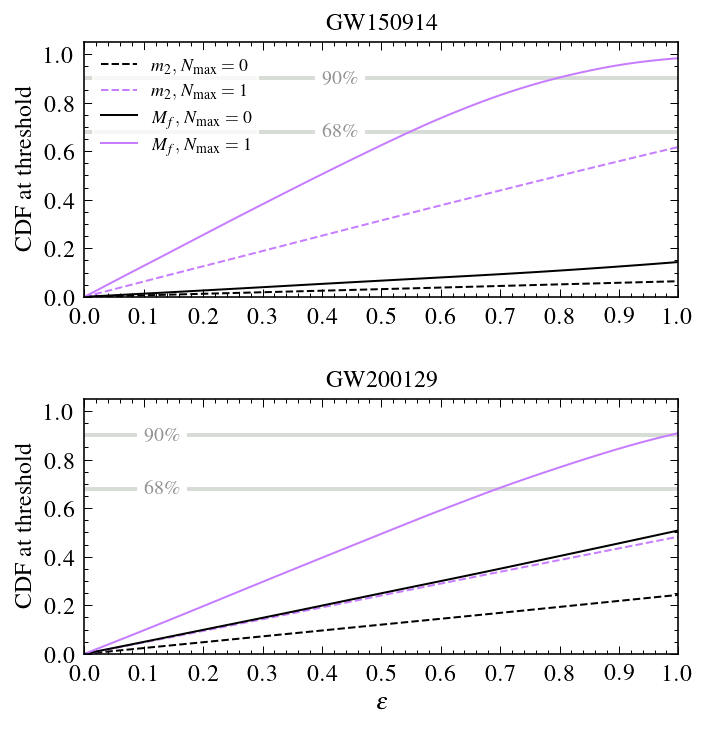

In [210]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B']]

clist = ["k", "#c77dff"]
lslist = ["dashed", "solid"]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.5, 'bottom': 0.1})
plt.tight_layout()

for k in ('A', 'B'):
    axes[k].set_xlim(0, 1)
    axes[k].set_ylim(0, 1.05)
    axes[k].xaxis.set_ticks(np.arange(0, 1 + 0.1, 0.1))
    axes[k].axhline(0.90, color='xkcd:light gray', lw=2)
    axes[k].axhline(0.68, color='xkcd:light gray', lw=2)

# -------
# Panel A
# -------
axes['A'].plot(eps_val, GW150914_m2_j0, color=clist[0], ls=lslist[0], label=r"$m_{2}, \, N_{\rm max}=0$")
axes['A'].plot(eps_val, GW150914_m2_j1, color=clist[1], ls=lslist[0], label=r"$m_{2}, \, N_{\rm max}=1$")
axes['A'].plot(eps_val, GW150914_mf_j0, color=clist[0], ls=lslist[1], label=r"$M_{f}, \, N_{\rm max}=0$")
axes['A'].plot(eps_val, GW150914_mf_j1, color=clist[1], ls=lslist[1], label=r"$M_{f}, \, N_{\rm max}=1$")
axes['A'].set_ylabel('CDF at threshold')
axes['A'].set_title("GW150914");
axes['A'].text(0.4, 0.90 - 0.03, r'$90\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
axes['A'].text(0.4, 0.68 - 0.02, r'$68\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
# axes['A'].legend(loc='lower right', frameon=False, fontsize=9, facecolor='white', edgecolor='white');
axes['A'].legend(loc='upper left', frameon=True, fontsize=9, facecolor='white', edgecolor='white');
axes['A'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

# -------
# Panel B
# -------
axes['B'].plot(eps_val, GW200129_m2_j0, color=clist[0], ls=lslist[0],  label=r"$m_{2}, \, N_{\rm max}=0$")
axes['B'].plot(eps_val, GW200129_m2_j1, color=clist[1], ls=lslist[0],  label=r"$m_{2}, \, N_{\rm max}=1$")
axes['B'].plot(eps_val, GW200129_mf_j0, color=clist[0], ls=lslist[1],  label=r"$M_{f}, \, N_{\rm max}=0$")
axes['B'].plot(eps_val, GW200129_mf_j1, color=clist[1], ls=lslist[1],  label=r"$M_{f}, \, N_{\rm max}=1$")
axes['B'].set_ylabel('CDF at threshold')
axes['B'].set_xlabel(r'$\varepsilon$')
axes['B'].set_title("GW200129");
axes['B'].text(0.1, 0.90 - 0.03, r'$90\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
axes['B'].text(0.1, 0.68 - 0.02, r'$68\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
# axes['B'].legend(loc='best', fontsize=9);
axes['B'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

plt.savefig('fig_output/edgb_cdf_varying_threshold.pdf')

In [ ]:
_, _ = find_bound(l_bins, GW150914_kde_j0(l_bins))
_, _ = find_bound(l_bins, GW200129_kde_j0(l_bins))
_, _ = find_bound(edgb_prior_j0, edgb_jpost_j0)

### 1.c. cubic EFT

In [180]:
data_GW200129_ceft_j0 = np.genfromtxt(dataloc['cEFT']['spin0']['GW200129'], names=True, dtype=None)
data_GW200129_ceft_j1 = np.genfromtxt(dataloc['cEFT']['spin1']['GW200129'], names=True, dtype=None)
data_GW150914_ceft_j0 = np.genfromtxt(dataloc['cEFT']['spin0']['GW150914'], names=True, dtype=None)
data_GW150914_ceft_j1 = np.genfromtxt(dataloc['cEFT']['spin1']['GW150914'], names=True, dtype=None)

In [234]:
GW200129_ceft_smp_l_j0, GW200129_ceft_smp_m1s_j0, GW200129_ceft_smp_m2s_j0, GW200129_ceft_smp_mfs_j0, GW200129_ceft_smp_z_j0 = read_relevant_columns(data_GW200129_ceft_j0)
GW200129_ceft_smp_l_j1, GW200129_ceft_smp_m1s_j1, GW200129_ceft_smp_m2s_j1, GW200129_ceft_smp_mfs_j1, GW200129_ceft_smp_z_j1 = read_relevant_columns(data_GW200129_ceft_j1)

GW150914_ceft_smp_l_j0, GW150914_ceft_smp_m1s_j0, GW150914_ceft_smp_m2s_j0, GW150914_ceft_smp_mfs_j0, GW150914_ceft_smp_z_j0 = read_relevant_columns(data_GW150914_ceft_j0)
GW150914_ceft_smp_l_j1, GW150914_ceft_smp_m1s_j1, GW150914_ceft_smp_m2s_j1, GW150914_ceft_smp_mfs_j1, GW150914_ceft_smp_z_j1 = read_relevant_columns(data_GW150914_ceft_j1)

In [235]:
ceft_prior_j0, ceft_jlike_j0, ceft_jpost_j0 = joint_likelihood_and_posterior(data_GW150914_ceft_j0, data_GW200129_ceft_j0, 80., 60.)
ceft_prior_j1, ceft_jlike_j1, ceft_jpost_j1 = joint_likelihood_and_posterior(data_GW150914_ceft_j1, data_GW200129_ceft_j1, 80., 60.)

/local/tmp/hosilva/ipykernel_1632243/4094030541.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


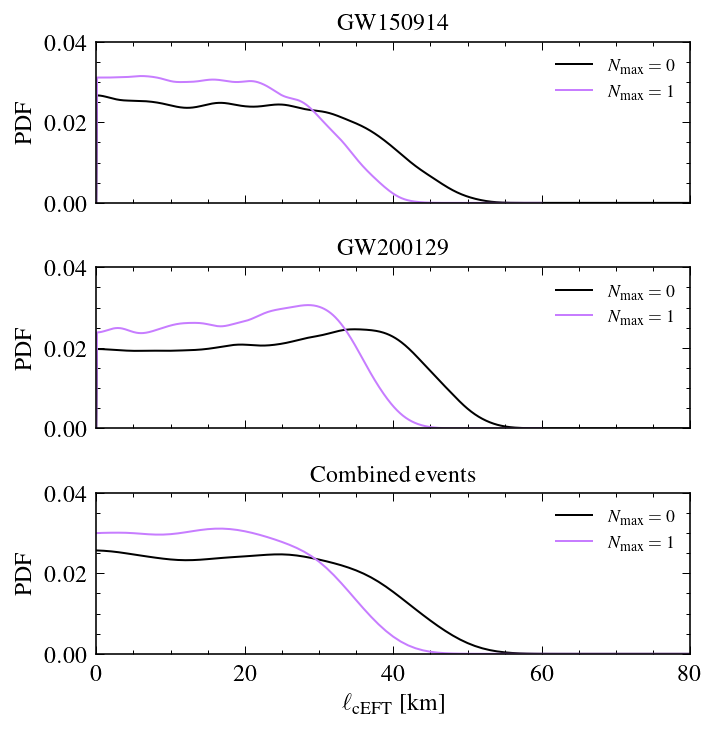

In [236]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B'],
     ['C', 'C', 'C']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.6, 'bottom':0.1})
plt.tight_layout()

clist = ["k", "#c77dff"]

for k in ('A', 'B', 'C'):
    axes[k].set_xlim(0, 80)
    axes[k].xaxis.set_ticks(np.arange(0, 80+20, 20))
    
for k in ('A', 'B'):
    axes[k].set_xticklabels([]);
    
axes['C'].set_xlabel(r'$\ell_{\rm cEFT}$ [km]');

l_bins=np.arange(0, 80 + 1/10., 1/10.)
GW150914_kde_j0 = ReflectionBoundedKDE(GW150914_ceft_smp_l_j0, xlow=min(GW150914_ceft_smp_l_j0))
axes['A'].plot(l_bins, GW150914_kde_j0(l_bins), color=clist[0], label=r"$N_{\rm max}=0$")

l_bins=np.arange(0, 60 + 1/10., 1/10.)
GW150914_kde_j1 = ReflectionBoundedKDE(GW150914_ceft_smp_l_j1, xlow=min(GW150914_ceft_smp_l_j1))
axes['A'].plot(l_bins, GW150914_kde_j1(l_bins), color=clist[1], label=r"$N_{\rm max}=1$")

axes['A'].set_ylim(0, 0.04);
axes['A'].yaxis.set_ticks([0, 0.02, 0.04]);
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper right', fontsize=9);
axes['A'].set_ylabel("PDF");

l_bins=np.arange(0, 80 + 1/10., 1/10.)
GW200129_kde_j0 = ReflectionBoundedKDE(GW200129_ceft_smp_l_j0, xlow=min(GW200129_ceft_smp_l_j0))
axes['B'].plot(l_bins, GW200129_kde_j0(l_bins), color=clist[0], label=r"$N_{\rm max}=0$")

l_bins=np.arange(0, 60 + 1/10., 1/10.)
GW200129_kde_j1 = ReflectionBoundedKDE(GW200129_ceft_smp_l_j1, xlow=min(GW200129_ceft_smp_l_j1))
axes['B'].plot(l_bins, GW200129_kde_j1(l_bins), color=clist[1], label=r"$N_{\rm max}=1$")

axes['B'].set_ylim(0, 0.04);
axes['B'].yaxis.set_ticks([0, 0.02, 0.04]);
axes['B'].set_title("GW200129");
axes['B'].legend(loc='upper right', fontsize=9);
axes['B'].set_ylabel("PDF");

axes['C'].set_title("Combined events");
axes['C'].set_ylabel("PDF");
axes['C'].plot(ceft_prior_j0, ceft_jpost_j0, '-',  color=clist[0], label=r"$N_{\rm max}=0$")
axes['C'].plot(ceft_prior_j1, ceft_jpost_j1, '-',  color=clist[1], label=r"$N_{\rm max}=1$")
axes['C'].legend(loc='upper right', fontsize=9);
axes['C'].set_ylim(0, 0.04);
axes['C'].yaxis.set_ticks([0, 0.02, 0.04]);

# plt.savefig('fig_output/ceft_posteriors_combined.pdf')

In [202]:
eps_val, GW150914_m2_j0 = find_cdf_at_threshold(GW150914_ceft_smp_m2s_j0, l_bins, GW150914_kde_j0(l_bins), lmax=80)
_,       GW150914_mf_j0 = find_cdf_at_threshold(GW150914_ceft_smp_mfs_j0, l_bins, GW150914_kde_j0(l_bins), lmax=80)

_,       GW150914_m2_j1 = find_cdf_at_threshold(GW150914_ceft_smp_m2s_j1, l_bins, GW150914_kde_j1(l_bins), lmax=60)
_,       GW150914_mf_j1 = find_cdf_at_threshold(GW150914_ceft_smp_mfs_j1, l_bins, GW150914_kde_j1(l_bins), lmax=60)

_,       GW200129_m2_j0 = find_cdf_at_threshold(GW200129_ceft_smp_m2s_j0, l_bins, GW200129_kde_j0(l_bins), lmax=80)
_,       GW200129_mf_j0 = find_cdf_at_threshold(GW200129_ceft_smp_mfs_j0, l_bins, GW200129_kde_j0(l_bins), lmax=80)

_,       GW200129_m2_j1 = find_cdf_at_threshold(GW200129_ceft_smp_m2s_j1, l_bins, GW200129_kde_j1(l_bins), lmax=60)
_,       GW200129_mf_j1 = find_cdf_at_threshold(GW200129_ceft_smp_mfs_j1, l_bins, GW200129_kde_j1(l_bins), lmax=60)

27.648314847745084 38.19960646147667 22.072716801216323
27.648314847745084 38.19960646147667 44.73583792145586
22.229016550018414 30.875031092763574 22.054432910041022
22.229016550018414 30.875031092763574 44.70159441935474
33.12572239850213 42.55303285012295 21.122816879036225
33.12572239850213 42.55303285012295 43.35925580788102
26.21831929067118 33.77952504359818 21.18884366837563
26.21831929067118 33.77952504359818 43.45231175275154


/local/tmp/hosilva/ipykernel_1632243/750074063.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


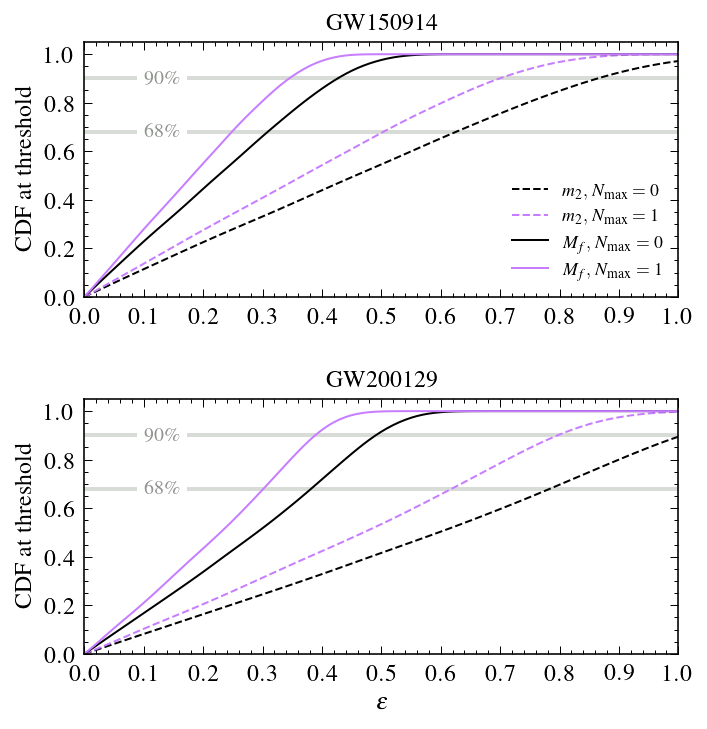

In [203]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B']]

clist = ["k", "#c77dff"]
lslist = ["dashed", "solid"]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.5, 'bottom': 0.1})
plt.tight_layout()

for k in ('A', 'B'):
    axes[k].set_xlim(0, 1)
    axes[k].set_ylim(0, 1.05)
    axes[k].xaxis.set_ticks(np.arange(0, 1 + 0.1, 0.1))
    axes[k].axhline(0.90, color='xkcd:light gray', lw=2)
    axes[k].axhline(0.68, color='xkcd:light gray', lw=2)

# -------
# Panel A
# -------
axes['A'].plot(eps_val, GW150914_m2_j0, color=clist[0], ls=lslist[0], label=r"$m_{2}, \, N_{\rm max}=0$")
axes['A'].plot(eps_val, GW150914_m2_j1, color=clist[1], ls=lslist[0], label=r"$m_{2}, \, N_{\rm max}=1$")
axes['A'].plot(eps_val, GW150914_mf_j0, color=clist[0], ls=lslist[1], label=r"$M_{f}, \, N_{\rm max}=0$")
axes['A'].plot(eps_val, GW150914_mf_j1, color=clist[1], ls=lslist[1], label=r"$M_{f}, \, N_{\rm max}=1$")
axes['A'].set_ylabel('CDF at threshold')
axes['A'].set_title("GW150914");
axes['A'].text(0.1, 0.90 - 0.03, r'$90\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
axes['A'].text(0.1, 0.68 - 0.02, r'$68\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
# axes['A'].legend(loc='lower right', frameon=False, fontsize=9, facecolor='white', edgecolor='white');
axes['A'].legend(loc='lower right', frameon=True, fontsize=9, facecolor='white', edgecolor='white');
axes['A'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

# -------
# Panel B
# -------
axes['B'].plot(eps_val, GW200129_m2_j0, color=clist[0], ls=lslist[0],  label=r"$m_{2}, \, N_{\rm max}=0$")
axes['B'].plot(eps_val, GW200129_m2_j1, color=clist[1], ls=lslist[0],  label=r"$m_{2}, \, N_{\rm max}=1$")
axes['B'].plot(eps_val, GW200129_mf_j0, color=clist[0], ls=lslist[1],  label=r"$M_{f}, \, N_{\rm max}=0$")
axes['B'].plot(eps_val, GW200129_mf_j1, color=clist[1], ls=lslist[1],  label=r"$M_{f}, \, N_{\rm max}=1$")
axes['B'].set_ylabel('CDF at threshold')
axes['B'].set_xlabel(r'$\varepsilon$')
axes['B'].set_title("GW200129");
axes['B'].text(0.1, 0.90 - 0.03, r'$90\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
axes['B'].text(0.1, 0.68 - 0.02, r'$68\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
# axes['B'].legend(loc='best', fontsize=9);
axes['B'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

plt.savefig('fig_output/ceft_cdf_varying_threshold.pdf')

In [237]:
_, _ = find_bound(l_bins, GW150914_kde_j0(l_bins))
_, _ = find_bound(l_bins, GW200129_kde_j0(l_bins))
_, _ = find_bound(ceft_prior_j0, ceft_jpost_j0)

27.648314847745052 38.19960646147667
33.12572239850213 42.553032850123
28.053485589516896 38.253155340862556


### 1.d. Quartic EFT

In [212]:
data_GW200129_qeft_j0 = np.genfromtxt(dataloc['qEFT']['spin0']['GW200129'], names=True, dtype=None)
# data_GW200129_qeft_j1 = np.genfromtxt(dataloc['qEFT']['spin1']['GW200129'], names=True, dtype=None)
data_GW150914_qeft_j0 = np.genfromtxt(dataloc['qEFT']['spin0']['GW150914'], names=True, dtype=None)
# data_GW150914_qeft_j1 = np.genfromtxt(dataloc['qEFT']['spin1']['GW150914'], names=True, dtype=None)

In [196]:
GW200129_qeft_smp_l_j0, GW200129_qeft_smp_m1s_j0, GW200129_qeft_smp_m2s_j0, GW200129_qeft_smp_mfs_j0, GW200129_qeft_smp_z_j0 = read_relevant_columns(data_GW200129_qeft_j0)
# GW200129_qeft_smp_l_j1, GW200129_ceft_smp_m1s_j1, GW200129_ceft_smp_m2s_j1, GW200129_ceft_smp_mfs_j1, GW200129_ceft_smp_z_j1 = read_relevant_columns(data_GW200129_ceft_j1)

GW150914_qeft_smp_l_j0, GW150914_qeft_smp_m1s_j0, GW150914_qeft_smp_m2s_j0, GW150914_qeft_smp_mfs_j0, GW150914_qeft_smp_z_j0 = read_relevant_columns(data_GW150914_qeft_j0)
# GW150914_qeft_smp_l_j1, GW150914_ceft_smp_m1s_j1, GW150914_ceft_smp_m2s_j1, GW150914_ceft_smp_mfs_j1, GW150914_ceft_smp_z_j1 = read_relevant_columns(data_GW150914_ceft_j1)

In [197]:
qeft_prior_j0, qeft_jlike_j0, qeft_jpost_j0 = joint_likelihood_and_posterior(data_GW150914_qeft_j0, data_GW200129_qeft_j0, 80., 100.)
# qeft_prior_j1, qeft_jlike_j1, qeft_jpost_j1 = joint_likelihood_and_posterior(data_GW150914_qeft_j1, data_GW200129_qeft_j1, 80., 60.)

/local/tmp/hosilva/ipykernel_1632243/979184090.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


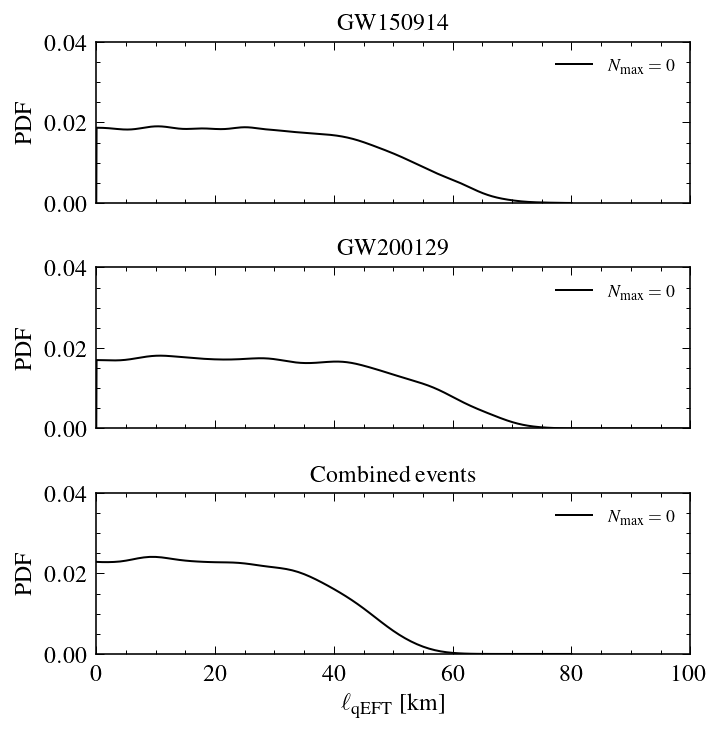

In [199]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B'],
     ['C', 'C', 'C']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.6, 'bottom':0.1})
plt.tight_layout()

clist = ["k", "#c77dff"]

for k in ('A', 'B', 'C'):
    axes[k].set_xlim(0, 100)
    axes[k].xaxis.set_ticks(np.arange(0, 100+20, 20))
    
for k in ('A', 'B'):
    axes[k].set_xticklabels([]);
    
axes['C'].set_xlabel(r'$\ell_{\rm qEFT}$ [km]');

l_bins=np.arange(0, 80 + 1/20., 1/20.)
GW150914_kde_j0 = ReflectionBoundedKDE(GW150914_qeft_smp_l_j0, xlow=min(GW150914_qeft_smp_l_j0))
axes['A'].plot(l_bins, GW150914_kde_j0(l_bins), color=clist[0], label=r"$N_{\rm max}=0$")

# l_bins=np.arange(0, 100 + 1/10., 1/10.)
# GW150914_kde_j1 = ReflectionBoundedKDE(GW150914_qeft_smp_l_j1, xlow=min(GW150914_qeft_smp_l_j1))
# axes['A'].plot(l_bins, GW150914_kde_j1(l_bins), color=clist[1], label=r"$N_{\rm max}=1$")

axes['A'].set_ylim(0, 0.04);
axes['A'].yaxis.set_ticks([0, 0.02, 0.04]);
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper right', fontsize=9);
axes['A'].set_ylabel("PDF");

l_bins=np.arange(0, 100 + 1/20., 1/20.)
GW200129_kde_j0 = ReflectionBoundedKDE(GW200129_qeft_smp_l_j0, xlow=min(GW200129_qeft_smp_l_j0))
axes['B'].plot(l_bins, GW200129_kde_j0(l_bins), color=clist[0], label=r"$N_{\rm max}=0$")

# l_bins=np.arange(0, 60 + 1/10., 1/10.)
# GW200129_kde_j1 = ReflectionBoundedKDE(GW200129_qeft_smp_l_j1, xlow=min(GW200129_qeft_smp_l_j1))
# axes['B'].plot(l_bins, GW200129_kde_j1(l_bins), color=clist[1], label=r"$N_{\rm max}=1$")

axes['B'].set_ylim(0, 0.04);
axes['B'].yaxis.set_ticks([0, 0.02, 0.04]);
axes['B'].set_title("GW200129");
axes['B'].legend(loc='upper right', fontsize=9);
axes['B'].set_ylabel("PDF");

axes['C'].set_title("Combined events");
axes['C'].set_ylabel("PDF");
axes['C'].plot(qeft_prior_j0, qeft_jpost_j0, '-',  color=clist[0], label=r"$N_{\rm max}=0$")
# axes['C'].plot(ceft_prior_j1, ceft_jpost_j1, '-',  color=clist[1], label=r"$N_{\rm max}=1$")
axes['C'].legend(loc='upper right', fontsize=9);
axes['C'].set_ylim(0, 0.04);
axes['C'].yaxis.set_ticks([0, 0.02, 0.04]);

plt.savefig('fig_output/qeft_posteriors_combined.pdf')

In [200]:
eps_val, GW150914_m2_j0 = find_cdf_at_threshold(GW150914_edgb_smp_m2s_j0, l_bins, GW150914_kde_j0(l_bins), lmax=80)
_,       GW150914_mf_j0 = find_cdf_at_threshold(GW150914_edgb_smp_mfs_j0, l_bins, GW150914_kde_j0(l_bins), lmax=80)

# _,       GW150914_m2_j1 = find_cdf_at_threshold(GW150914_edgb_smp_m2s_j1, l_bins, GW150914_kde_j1(l_bins), lmax=100)
# _,       GW150914_mf_j1 = find_cdf_at_threshold(GW150914_edgb_smp_mfs_j1, l_bins, GW150914_kde_j1(l_bins), lmax=100)

_,       GW200129_m2_j0 = find_cdf_at_threshold(GW200129_edgb_smp_m2s_j0, l_bins, GW200129_kde_j0(l_bins), lmax=100)
_,       GW200129_mf_j0 = find_cdf_at_threshold(GW200129_edgb_smp_mfs_j0, l_bins, GW200129_kde_j0(l_bins), lmax=100)

# _,       GW200129_m2_j1 = find_cdf_at_threshold(GW200129_edgb_smp_m2s_j1, l_bins, GW200129_kde_j1(l_bins), lmax=200)
# _,       GW200129_mf_j1 = find_cdf_at_threshold(GW200129_edgb_smp_mfs_j1, l_bins, GW200129_kde_j1(l_bins), lmax=200)

37.00940708011212 51.67669821235551 22.081519018252397
37.00940708011212 51.67669821235551 45.84189029871594
39.579387636634216 54.78628138124329 21.35905928669088
39.579387636634216 54.78628138124329 43.86453770391392


/local/tmp/hosilva/ipykernel_1632243/803745370.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


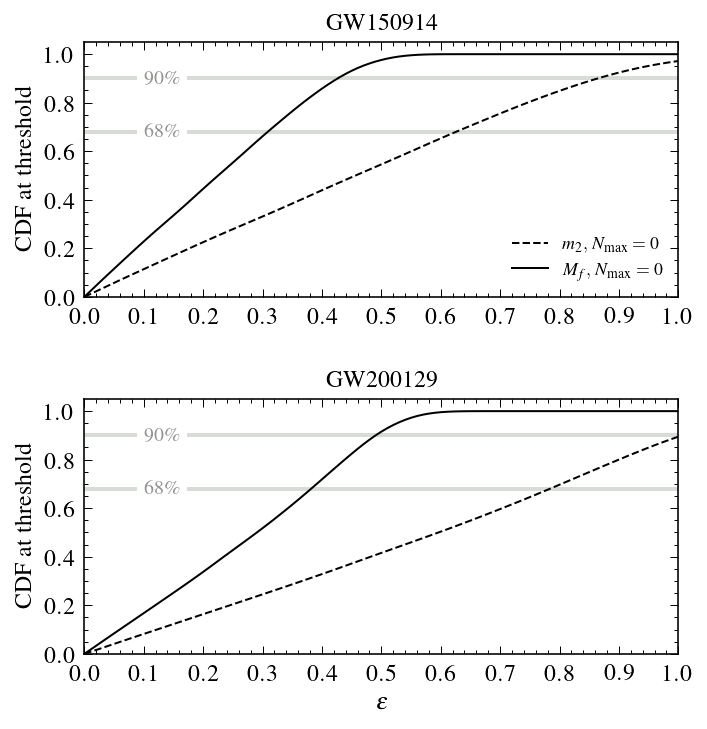

In [206]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B']]

clist = ["k", "#c77dff"]
lslist = ["dashed", "solid"]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.5, 'bottom': 0.1})
plt.tight_layout()

for k in ('A', 'B'):
    axes[k].set_xlim(0, 1)
    axes[k].set_ylim(0, 1.05)
    axes[k].xaxis.set_ticks(np.arange(0, 1 + 0.1, 0.1))
    axes[k].axhline(0.90, color='xkcd:light gray', lw=2)
    axes[k].axhline(0.68, color='xkcd:light gray', lw=2)

# -------
# Panel A
# -------
axes['A'].plot(eps_val, GW150914_m2_j0, color=clist[0], ls=lslist[0], label=r"$m_{2}, \, N_{\rm max}=0$")
# axes['A'].plot(eps_val, GW150914_m2_j1, color=clist[1], ls=lslist[0], label=r"$m_{2}, \, j=0,1$")
axes['A'].plot(eps_val, GW150914_mf_j0, color=clist[0], ls=lslist[1], label=r"$M_{f}, \, N_{\rm max}=0$")
# axes['A'].plot(eps_val, GW150914_mf_j1, color=clist[1], ls=lslist[1], label=r"$M_{f}, \, j=0,1$")
axes['A'].set_ylabel('CDF at threshold')
axes['A'].set_title("GW150914");
axes['A'].text(0.1, 0.90 - 0.03, r'$90\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
axes['A'].text(0.1, 0.68 - 0.02, r'$68\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
# axes['A'].legend(loc='lower right', frameon=False, fontsize=9, facecolor='white', edgecolor='white');
axes['A'].legend(loc='lower right', frameon=True, fontsize=9, facecolor='white', edgecolor='white');
axes['A'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

# -------
# Panel B
# -------
axes['B'].plot(eps_val, GW200129_m2_j0, color=clist[0], ls=lslist[0],  label=r"$m_{2}, \, N_{\rm max}=0$")
# axes['B'].plot(eps_val, GW200129_m2_j1, color=clist[1], ls=lslist[0],  label=r"$m_{2}, \, N_{\rm max}=1$")
axes['B'].plot(eps_val, GW200129_mf_j0, color=clist[0], ls=lslist[1],  label=r"$M_{f}, \, N_{\rm max}=0$")
# axes['B'].plot(eps_val, GW200129_mf_j1, color=clist[1], ls=lslist[1],  label=r"$M_{f}, \, N_{\rm max}=1$")
axes['B'].set_ylabel('CDF at threshold')
axes['B'].set_xlabel(r'$\varepsilon$')
axes['B'].set_title("GW200129");
axes['B'].text(0.1, 0.90 - 0.03, r'$90\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
axes['B'].text(0.1, 0.68 - 0.02, r'$68\%$', fontsize=10, color='xkcd:gray', bbox=dict(boxstyle="square", ec='white', fc='white',))
# axes['B'].legend(loc='best', fontsize=9);
axes['B'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

plt.savefig('fig_output/qeft_cdf_varying_threshold.pdf')

In [ ]:
plt.hist(data_GW150914_qeft_j1["alphaNGR"], 